# Linear Regression

## 0. Overview

In this notebook, I will briefly motivate linear regression and the theory behind it. Then we will look at a simple example using data from <a href="https://www.kaggle.com">Kaggle's</a> housing price competition.

## 1. Motivation & Theory
### Motivation
Linear regression is usually one of the first machine learning algorithms that people learn. Its aim is to take a set of data points $(x_i, y_i)$ and find a best fit linear mapping from the independent variable $x$ to the dependent variable $y$. Once armed with this linear mapping, we can make a prediction about some new value of $y$ when given a new value of $x$. This is a useful tool when trying to predict values of a continuous nature, such as the typical example of predicting housing prices given some input variable, $\textit{e.g.}$ the house's square footage.

### What makes a best fit?
What do we mean when we say that some function is a best fit to data points? We need a cost function that we will want to minimize in order to say that we have a best fit. In this case, our cost function will be the sum of distances squared of each point in the data to the best fit line. In other words, the best fit line is the line that minimizes the square of the distance of every point from that line.

For a single point $(x_i, y_i)$ where the best fit line is $y(x) = \alpha x + \beta$, the square of the distance from the best fit line is

\begin{equation}
d_i^2 = \left[y_i - y(x_i)\right]^2 = \left[y_i - \alpha x_i - \beta\right]^2.
\end{equation}

Keep in mind that this is just for one point. The cost function $J(\theta)$ is the sum of all of these distances,

\begin{equation}
J(\mathbf{\Theta}) = \sum_{i = 0}^{N - 1} \left[y_i - \left(\theta_0 + \theta_1 x_i\right)\right]^2
\end{equation}

where $N$ is the number of points in our data set, and we have replaced the linear parameters $\alpha, \beta$ with more general $\theta_i$ parameters encapsulated by the vector $\mathbf{\Theta}$. This equation can easily be extended to linear functions with multiple input variables. In general, for multivariate linear regression with $M$ input variables

\begin{equation}
y_j = \theta_0 + \sum_{i = 1}^{M}\theta_i x_{ij}.
\end{equation}

Note that what we have in the expression for the cost function $J(\mathbf{\Theta})$ is quadratic in the fit parameters $\theta_i$. This creates a parabolic "bowl" shape for which we can find a minimum at points $(\overline{\theta}_0, \overline{\theta}_1)$. Once we have found the $\overline{\theta}_i$ that minimize our cost function, we can plot the best fit line

\begin{equation}
y_{best} = \overline{\theta}_0 + \overline{\theta}_1 x.
\end{equation}

### An Example

Let's create a generic noisy data set with 1,000 points. Then, we will build a linear regressor that will terminate fitting once it has reached the bottom of the "bowl", $\textit{i.e.}$ when the derivative of the cost function with respect to either value of $\theta_i$ is smaller than some tolerance.

This is by no means the fastest or most robust algorithm for linear regression, but it serves as a simple example of how linear regression works.

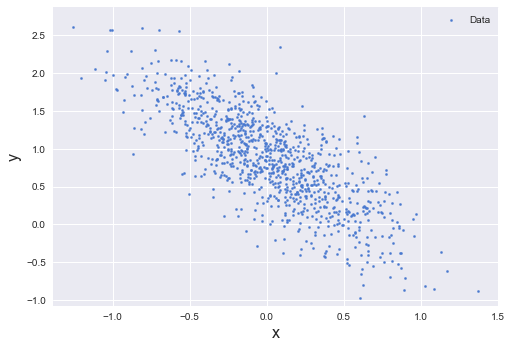

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

#generate 1000 x,y pairs with intercept and slope that we want to 
#recover using linear regression
intercept = 0.86
slope = -1.2
np.random.seed(1)
noise = np.random.normal(loc=0, scale=0.4, size=1000) # add some noise to the data
x = np.random.normal(loc=0, scale=0.4, size=1000)
y = intercept + slope * x + noise

sns.set_style(style='darkgrid')
sns.set_color_codes(palette='muted')
plt.scatter(x, y, s=5, c='b', label='Data')
plt.xlim(xmin=1.1*x.min(), xmax=1.1*x.max())
plt.ylim(ymin=1.1*y.min(), ymax=1.1*y.max())
plt.xlabel('x', size=16)
plt.ylabel('y', size=16)
plt.legend(loc='upper right')
plt.show()

Clearly our fake data set has a linear trend, as we would expect since we created it that way. Let's create a class to handle linear regression on this data set.

In [2]:
class MyLinearRegressor(object):
    
    def __init__(self, x, y, epsilon=1e-3, step_size=1e-3, start=(0,0)):
    
        """
        :param: data = set of x,y data pairs to be fit
        :param: epsilon = tolerance
        :param: step_size = size of step in each parameter
        :param: start = tuple for starting point in linear params space
        
        Perform linear regression on a data set (x, y) and terminate
        once we find the fit parameters where both derivatives w.r.t.
        the fit parameters of the cost function are below the tolerance 
        epsilon.
        """
        
        self.x = x
        self.y = y
        self.epsilon = epsilon
        self.step_size = step_size
        self.fit_params = start
        self.current_cost_func = self.cost_function(start[0], start[1])
        
    def cost_function(self, param_0, param_1):
        """ 
        Function to be minimized
        """
        return np.sum(np.square(self.y - param_0 - param_1 * self.x))
    
    def take_step(self):
        
        theta_0 = self.fit_params[0]
        theta_1 = self.fit_params[1]
        
        # find slope as funct of theta_0
        self.slope_0 = (self.cost_function(theta_0 + self.step_size, theta_1) - self.current_cost_func) / self.step_size
        self.slope_1 = (self.cost_function(theta_0, theta_1 + self.step_size) - self.current_cost_func) / self.step_size
        
        theta_0 += -1 * self.slope_0 * self.step_size
        theta_1 += -1 * self.slope_1 * self.step_size

        self.fit_params = (theta_0, theta_1)
        self.current_cost_func = self.cost_function(theta_0, theta_1)
        
    def fit(self):
        
        loop_condition = True
        while loop_condition:
            
            self.take_step()
            
            if (abs(self.slope_0) < self.epsilon) and (abs(self.slope_1) < self.epsilon):
                loop_condition = False
                

Now we'll perform linear regression using our algorithm, and the scipy.stats algorithm and compare the results.

In [3]:
lin_reg = MyLinearRegressor(x, y, epsilon=1e-5, step_size=1e-5)
lin_reg.fit()

fit_intercept = lin_reg.fit_params[0]
fit_slope = lin_reg.fit_params[1]

sp_linregress = linregress(x,y)

print "               Intercept       Slope"
print "****************************************"
print "Actual value:    %.5f      %.5f"%(intercept, slope)
print "Fit value   :    %.5f      %.5f"%(fit_intercept, fit_slope)
print "linregress  :    %.5f      %.5f"%(sp_linregress.intercept, sp_linregress.slope)

               Intercept       Slope
****************************************
Actual value:    0.86000      -1.20000
Fit value   :    0.87529      -1.17919
linregress  :    0.87530      -1.17918


The results are nearly identical between our algorithm and scipy's. Finally, what does the best fit line look like plotted against our generic data set?

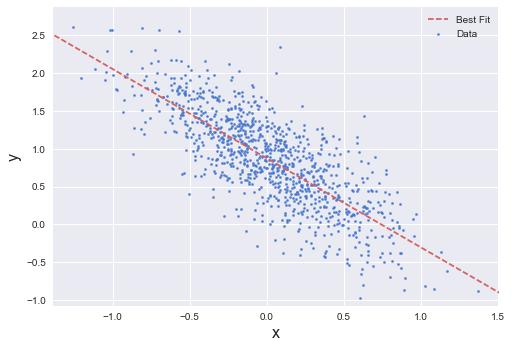

In [4]:
plt.scatter(x, y, c='b', s=5, label='Data')
temp_x = np.arange(-2, 2, 0.01)
plt.plot(temp_x, fit_intercept + fit_slope * temp_x, linestyle='--', color='r', label='Best Fit')
plt.xlim(xmin=1.1*x.min(), xmax=1.1*x.max())
plt.ylim(ymin=1.1*y.min(), ymax=1.1*y.max())
plt.xlabel('x', size=16)
plt.ylabel('y', size=16)
plt.legend(loc='upper right')
plt.show()

## 2. Housing Price Prediction

Let's use a real world data set with sklearn.linear_model.LinearRegression. I've downloaded the <a href="https://www.kaggle.com/c/house-prices-advanced-regression-techniques">housing prices data set</a> from Kaggle, and we'll use it to look at the price of a home as a function of some of its features.

First we'll load the data set into a pandas DataFrame and see what kinds of features there are, and which ones have a good correlation with housing price.

In [5]:
import pandas as pd
from sklearn.linear_model import LinearRegression

train_df = pd.read_csv('./data/housing_train.csv')
print train_df.corr()['SalePrice']

Id              -0.021917
MSSubClass      -0.084284
LotFrontage      0.351799
LotArea          0.263843
OverallQual      0.790982
OverallCond     -0.077856
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.477493
BsmtFinSF1       0.386420
BsmtFinSF2      -0.011378
BsmtUnfSF        0.214479
TotalBsmtSF      0.613581
1stFlrSF         0.605852
2ndFlrSF         0.319334
LowQualFinSF    -0.025606
GrLivArea        0.708624
BsmtFullBath     0.227122
BsmtHalfBath    -0.016844
FullBath         0.560664
HalfBath         0.284108
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
TotRmsAbvGrd     0.533723
Fireplaces       0.466929
GarageYrBlt      0.486362
GarageCars       0.640409
GarageArea       0.623431
WoodDeckSF       0.324413
OpenPorchSF      0.315856
EnclosedPorch   -0.128578
3SsnPorch        0.044584
ScreenPorch      0.111447
PoolArea         0.092404
MiscVal         -0.021190
MoSold           0.046432
YrSold          -0.028923
SalePrice        1.000000
Name: SalePr

From the list of correlations, we can see that "OverallQual", "YearBuilt", "GrLivArea", "GarageCars", & "GarageArea" correlate well with "SalePrice". There is no feature for total square footage of a house, but we can just make one by adding the other square footage features together. Then, we'll look at the scatter plot of "SalePrice" with each of the highly correlated features. 

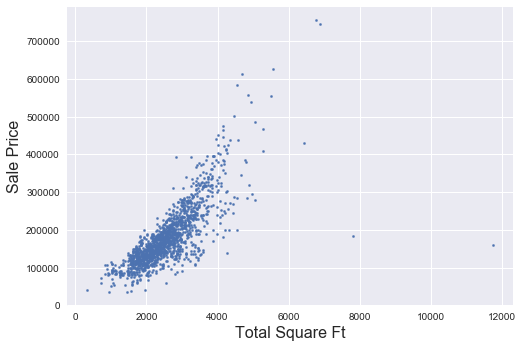

In [6]:
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
plt.scatter(train_df['TotalSF'], train_df.SalePrice, s=5)
plt.xlabel('Total Square Ft', size=16)
plt.ylabel('Sale Price', size=16)
plt.show()

There's definitely a relationship between "TotalSF" and "SalePrice", but there are a couple points with "TotalSF" > 7800sqft that look to be outliers.

In [7]:
train_df[(train_df.TotalSF > 6000) & (train_df.SalePrice < 200000)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,NaN,NaN,NaN,0,10,2007,New,Partial,184750,7814
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,Gd,NaN,NaN,0,1,2008,New,Partial,160000,11752


Let's just take these rows out and look at the scatter plot again, but without those two points.

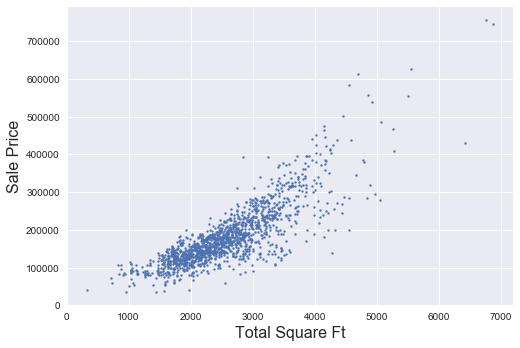

In [8]:
train_df = train_df[train_df.TotalSF < 7800]
plt.scatter(train_df.TotalSF, train_df.SalePrice, s=4)
plt.xlabel('Total Square Ft', size=16)
plt.ylabel('Sale Price', size=16)
plt.show()

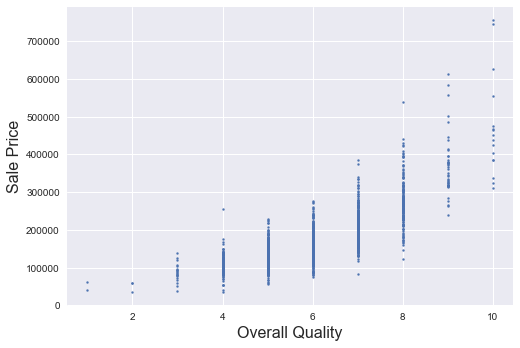

In [9]:
plt.scatter(train_df.OverallQual, train_df.SalePrice, s=4)
plt.xlabel('Overall Quality', size=16)
plt.ylabel('Sale Price', size=16)
plt.show()

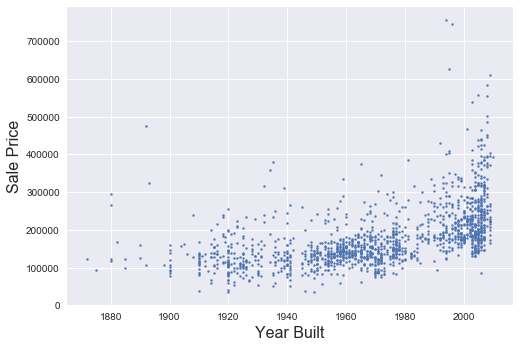

In [10]:
plt.scatter(train_df.YearBuilt, train_df.SalePrice, s=4)
plt.xlabel('Year Built', size=16)
plt.ylabel('Sale Price', size=16)
plt.show()

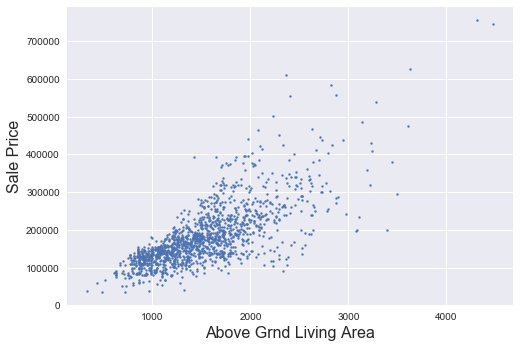

In [11]:
plt.scatter(train_df.GrLivArea, train_df.SalePrice, s=4)
plt.xlabel('Above Grnd Living Area', size=16)
plt.ylabel('Sale Price', size=16)
plt.show()

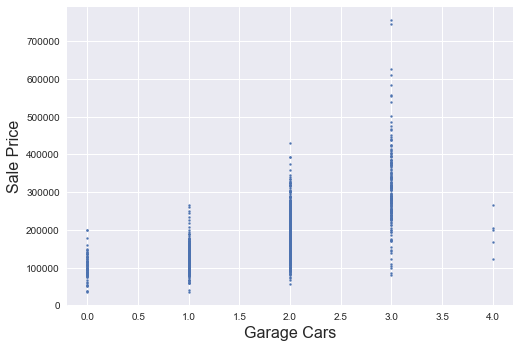

In [12]:
plt.scatter(train_df.GarageCars, train_df.SalePrice, s=4)
plt.xlabel('Garage Cars', size=16)
plt.ylabel('Sale Price', size=16)
plt.show()

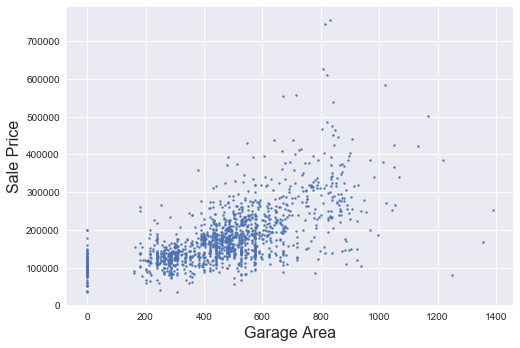

In [13]:
plt.scatter(train_df.GarageArea, train_df.SalePrice, s=4)
plt.xlabel('Garage Area', size=16)
plt.ylabel('Sale Price', size=16)
plt.show()

In [14]:
train_df = train_df[['OverallQual', 'GrLivArea', 'YearBuilt', 'GarageCars', 'GarageArea', 'TotalSF', 'SalePrice']]

In [15]:
print train_df.corr()['SalePrice']

OverallQual    0.795774
GrLivArea      0.734968
YearBuilt      0.523608
GarageCars     0.641047
GarageArea     0.629217
TotalSF        0.832877
SalePrice      1.000000
Name: SalePrice, dtype: float64


Now we'll train our linear regressor. We'll split our training data into two subsets: the first set we'll use to train our regressor, and the second we'll use for validation later. This can be accomplished using <i>train_test_split</i>. Once we have new training and validation sets, we will then scale and transform the training and validation data to have zero mean and unit variance. We'll do this since the feature scales are different from each other. Then we will perform a grid search over a few linear regression parameters in order to determine which set of parameters produces the best score as determined by the "scoring" value in GridSearchCV. We will also use 10-fold cross validation on the training set.

In [16]:
X = train_df.drop(['SalePrice'], axis=1)
Y = train_df.SalePrice
x_train, x_test, y_train, y_test = train_test_split(X, Y)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

test_params = {'fit_intercept':[True, False],
               'normalize':[True, False]
              }
              
linreg = LinearRegression(n_jobs=1)

np.random.seed(1)
linreg_grid_search = GridSearchCV(linreg, test_params, n_jobs=1, verbose=1, scoring='neg_mean_squared_error', cv=10)
linreg_grid_search.fit(x_train_scaled, np.log10(y_train))

print 'Best Score: %0.5e'%linreg_grid_search.best_score_
print 'Best Parameters:'
best_parameters = linreg_grid_search.best_estimator_.get_params()
for param_name in sorted(test_params.keys()):
    print '\t%s: %r'%(param_name, best_parameters[param_name])
    
predictions = linreg_grid_search.predict(x_test_scaled)
print "Mean Sqrd Error on final test set: ",mean_squared_error(predictions, np.log10(y_test))

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best Score: -5.00589e-03
Best Parameters:
	fit_intercept: True
	normalize: True
Mean Sqrd Error on final test set:  0.00342611771466


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s finished


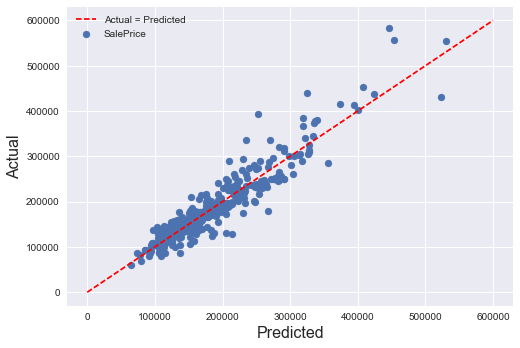

In [17]:
plt.scatter(10**predictions, y_test)
plt.plot(np.arange(600000), np.arange(600000), linestyle='--', color='red', label='Actual = Predicted')
plt.xlabel('Predicted', size=16)
plt.ylabel('Actual', size=16)
plt.legend(loc='upper left')
plt.show()

This last plot shows a scatter of our predicted housing prices and the actual housing prices from the validation set that we set aside when we used <i>train_test_split</i>. The dashed red line shows where the scatter points would lie had we guessed the price exactly. All of these points are fairly close to the line.